In this notebook, we will work through the vanishing gradients problem through several visualizations. We will look at a few ways to address this problem and understand them through visualizations.

### Imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(0)

### Generating data

In [4]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D), dtype='float32') # data matrix (each row = single example)
y = np.zeros(N*K, dtype='int32') # class labels

In [5]:
for j in xrange(K):
    indices = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[indices] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[indices] = j

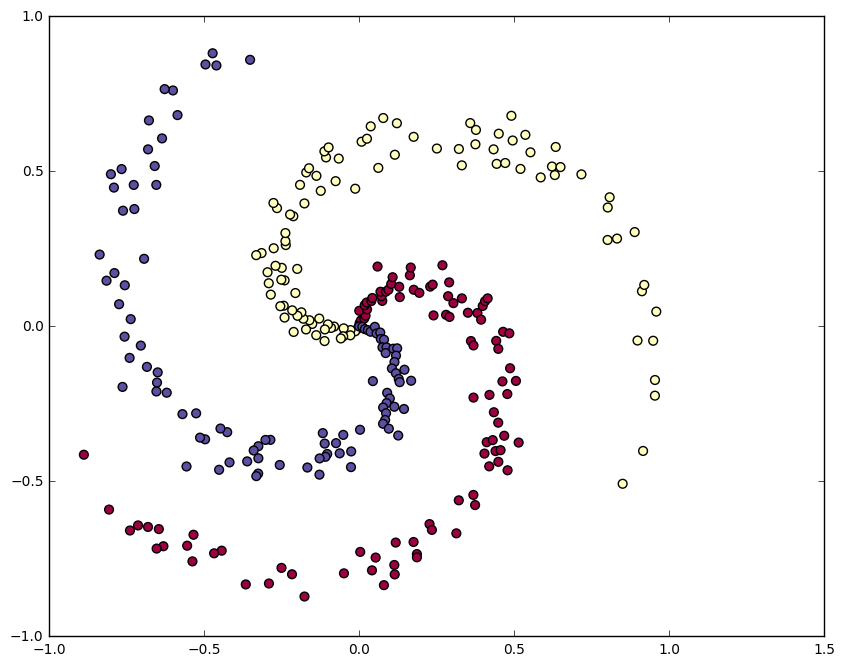

In [6]:
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

#### Let's first design and implement a Multi-Layer Neural Network class.
#### It takes number of layers and hidden nodes as some of its parameters

In [8]:
# An utility function to compute the sigmoid activation
def sigmoid(scores):
    #shift the values of scores so that the highest number is 0 - avoids numerical blowup while exponentiating
    max_zero_scores = scores - np.max(scores)
    exp_scores = np.exp(max_zero_scores)
    probas = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probas
# An utility function to compute the ReLU activation
def relu(scores):
    scores[scores <= 0] = 0
    return scores
# An utility function to compute the sigmoid gradient
def sigmoid_gradient(scores):
    return scores * (1-scores)

In [116]:
class MultiLayerSGDNeuralNetwork(object):
    def __init__(self, input_shape, labels_shape, num_classes,
             num_hidden_nodes, num_iterations=10000, learning_rate=1e-0, 
             reg_constant=1e-3, W_init_type='Glorot', sigma_W_init=0.1,
             activation_function='relu', track_gradients=False, track_weights=False):
        # initialize parameters of the network
        self.num_examples = input_shape[0]
        self.num_classes = num_classes
        self.num_hidden_layers = num_hidden_nodes.shape[0]
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.reg_constant = reg_constant
        self.activation_function = activation_function
        self.track_gradients = track_gradients
        self.track_weights = track_weights
        
        self.params = {}
        
        if self.track_gradients:
            self.params['dW_init_history'] = []
            for i in range(self.num_hidden_layers):
                self.params['dWh_'+str(i+1)+'_history'] = []
                self.params['dh_'+str(i+1)+'_history'] = []
                
        if self.track_weights:
            self.params['W_init_history'] = []
            for i in range(self.num_hidden_layers):
                self.params['Wh_'+str(i+1)+'_history'] = []
        
        # Glorot/Xavier initialization
        if W_init_type == 'glorot':
            if len(num_hidden_nodes):
                sigma_W_init = np.sqrt(float(2)/(input_shape[1]+num_hidden_nodes[0]))
                self.params['W_init'] = sigma_W_init * np.random.randn(input_shape[1],num_hidden_nodes[0])
                self.params['b_init'] = np.zeros((1,num_hidden_nodes[0]))
                
                for i in range(self.num_hidden_layers):
                    if i == self.num_hidden_layers - 1:
                        sigma_Wh = np.sqrt(float(2)/(num_hidden_nodes[i]+num_classes))
                        self.params['Wh_'+str(i+1)] = sigma_Wh * np.random.randn(num_hidden_nodes[i],num_classes)
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_classes))
                    else:
                        sigma_Wh = np.sqrt(float(2)/(num_hidden_nodes[-1]+num_hidden_nodes[-1]))
                        self.params['Wh_'+str(i+1)] = sigma_Wh * np.random.randn(num_hidden_nodes[-1],num_hidden_nodes[-1])
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_hidden_nodes[-1]))
            else:
                sigma_W_init = np.sqrt(float(2)/(input_shape[1]+num_classes))
                self.params['W_init'] = sigma_W_init * np.random.randn(input_shape[1],num_classes)
                self.params['b_init'] = np.zeros((1,num_classes))

        # Kaiming initialization
        elif W_init_type == 'kaiming':
            if len(num_hidden_nodes):
                sigma_W_init = np.sqrt(float(2)/input_shape[1])
                self.params['W_init'] = sigma_W_init * np.random.randn(input_shape[1],num_hidden_nodes[0])
                self.params['b_init'] = np.zeros((1,num_hidden_nodes[0]))

                for i in range(self.num_hidden_layers):
                    if i == self.num_hidden_layers - 1:
                        sigma_Wh = np.sqrt(float(2)/num_hidden_nodes[i])
                        self.params['Wh_'+str(i+1)] = sigma_Wh * np.random.randn(num_hidden_nodes[i],num_classes)
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_classes))
                    else:
                        sigma_Wh = np.sqrt(float(2)/num_hidden_nodes[-1])
                        self.params['Wh_'+str(i+1)] = sigma_Wh * np.random.randn(num_hidden_nodes[-1],num_hidden_nodes[-1])
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_hidden_nodes[-1]))
            else:
                sigma_W_init = np.sqrt(float(2)/(input_shape[1]))
                self.params['W_init'] = sigma_W_init * np.random.randn(input_shape[1],num_classes)
                self.params['b_init'] = np.zeros((1,num_classes))
                
        # all zero initialization
        elif W_init_type == 'zeros':
            if len(num_hidden_nodes):
                self.params['W_init'] = 0 * np.random.randn(input_shape[1],num_hidden_nodes[0])
                self.params['b_init'] = np.zeros((1,num_hidden_nodes[0]))

                for i in range(self.num_hidden_layers):
                    if i == self.num_hidden_layers - 1:
                        sigma_Wh = np.sqrt(float(2)/num_hidden_nodes[i])
                        self.params['Wh_'+str(i+1)] = 0 * np.random.randn(num_hidden_nodes[i],num_classes)
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_classes))
                    else:
                        sigma_Wh = np.sqrt(float(2)/num_hidden_nodes[-1])
                        self.params['Wh_'+str(i+1)] = 0 * np.random.randn(num_hidden_nodes[-1],num_hidden_nodes[-1])
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_hidden_nodes[-1]))
            else:
                self.params['W_init'] = 0 * np.random.randn(input_shape[1],num_classes)
                self.params['b_init'] = np.zeros((1,num_classes))
        
        # a custom initialization with 0.05 sigma from a normal distribution
        elif W_init_type == '0.05_sigma':
            if len(num_hidden_nodes):
                self.params['W_init'] = 0.05 * np.random.randn(input_shape[1],num_hidden_nodes[0])
                self.params['b_init'] = np.zeros((1,num_hidden_nodes[0]))

                for i in range(self.num_hidden_layers):
                    if i == self.num_hidden_layers - 1:
                        self.params['Wh_'+str(i+1)] = 0.05 * np.random.randn(num_hidden_nodes[i],num_classes)
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_classes))
                    else:
                        self.params['Wh_'+str(i+1)] = 0.05 * np.random.randn(num_hidden_nodes[-1],num_hidden_nodes[-1])
                        self.params['bh_'+str(i+1)] = np.zeros((1,num_hidden_nodes[-1]))
            else:
                self.params['W_init'] = 0.05 * np.random.randn(input_shape[1],num_classes)
                self.params['b_init'] = np.zeros((1,num_classes))
        
        self.num_iterations = num_iterations
        
    def compute_scores_and_loss(self, X, y):
        # compute the loss: average cross-entropy loss and regularization
        
        # evaluate class scores
        # Forward pass
        scores_list = []
        for i in range(self.num_hidden_layers+1):    
            if i == 0:
                hidden_scores = np.dot(X, self.params['W_init']) + self.params['b_init']
                if self.activation_function == 'relu' and self.num_hidden_layers != 0:
                    # compute the relu activations
                    hidden_scores = relu(hidden_scores)
                elif self.activation_function == 'sigmoid' or self.num_hidden_layers == 0:
                    # compute the sigmoid/softmax activations
                    hidden_scores = sigmoid(hidden_scores)
                    
                scores_list.append(hidden_scores)
            else:        
                scores = np.dot(scores_list[i-1], self.params['Wh_'+str(i)]) + self.params['bh_'+str(i)]
                if i != self.num_hidden_layers:    
                    if self.activation_function == 'relu':
                        # compute the relu activations
                        scores = relu(scores)
                    elif self.activation_function == 'sigmoid':
                        scores = sigmoid(scores)
                else:
                    # the last layer is always softmax
                    scores = sigmoid(scores)
                scores_list.append(scores)
        
        final_probas = scores_list[-1]
        correct_logprobs = -np.log(final_probas[range(self.num_examples),y])
        data_loss = np.sum(correct_logprobs)/self.num_examples
        
        reg_loss = 0.5*self.reg_constant*np.sum(self.params['W_init']*self.params['W_init'])
        for i in range(self.num_hidden_layers): 
            reg_loss += 0.5*self.reg_constant*np.sum(self.params['Wh_'+str(i+1)]*self.params['Wh_'+str(i+1)])
            
        loss = data_loss + reg_loss
        return scores_list, final_probas, loss
    
    def __compute_gradients(self, X, y, final_probas, scores_list):
        num_examples = self.num_examples
        
        # Compute the gradient on scores
        dscores = final_probas
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples
 
        # Back Propagation
        if self.num_hidden_layers == 0:
            # backpropagate the gradient to the first layer
            self.params['dW_init'] =  np.dot(X.T, dscores)
            self.params['db_init'] = np.sum(dscores, axis=0, keepdims=True)

            # add regularization
            self.params['dW_init'] += self.reg_constant*self.params['W_init']
        else:
            for i in range(self.num_hidden_layers+1):
                idx = self.num_hidden_layers-i
                if idx == 0:
                    # backpropagate the gradient to the first layer
                    self.params['dW_init'] =  np.dot(X.T, self.params['dh_1'])
                    self.params['db_init'] = np.sum(self.params['dh_1'], axis=0, keepdims=True)

                    # add regularization
                    self.params['dW_init'] += self.reg_constant*self.params['W_init']
                elif idx == self.num_hidden_layers:
                    # backpropagate the gradient from the final layer
                    self.params['dWh_'+str(idx)] = (scores_list[idx-1].T).dot(dscores)
                    self.params['dbh_'+str(idx)] = np.sum(dscores, axis=0, keepdims=True)
                    self.params['dh_'+str(idx)] = np.dot(dscores, self.params['Wh_'+str(idx)].T)
                    if self.activation_function == 'relu':
                        # backpropagate through ReLU nonlinearity
                        self.params['dh_'+str(idx)][scores_list[idx-1] <= 0] = 0
                    elif self.activation_function == 'sigmoid':
                        # backpropagate through sigmoid nonlinearity
                        self.params['dh_'+str(idx)] = self.params['dh_'+str(idx)] * sigmoid_gradient(scores_list[idx-1])
                    # add regularization
                    self.params['dWh_'+str(idx)] += self.reg_constant*self.params['Wh_'+str(idx)]
                else:
                    # backpropagate the gradient to the hidden layer
                    self.params['dWh_'+str(idx)] =  np.dot( scores_list[idx-1].T, self.params['dh_'+str(idx+1)])
                    self.params['dbh_'+str(idx)] = np.sum(self.params['dh_'+str(idx+1)], axis=0, keepdims=True)
                    self.params['dh_'+str(idx)] = np.dot(self.params['dh_'+str(idx+1)], self.params['Wh_'+str(idx)].T)
                    if self.activation_function == 'relu':
                        # backpropagate through ReLU nonlinearity
                        self.params['dh_'+str(idx)][scores_list[idx-1] <= 0] = 0
                    elif self.activation_function == 'sigmoid':
                        # backpropagate through sigmoid nonlinearity
                        self.params['dh_'+str(idx)] = self.params['dh_'+str(idx)] * sigmoid_gradient(scores_list[idx-1])
                    # add regularization
                    self.params['dWh_'+str(idx)] += self.reg_constant*self.params['Wh_'+str(idx)]
    def fit(self, X, y):
        losses = []
        # stochastic gradient descent loop
        for i in xrange(self.num_iterations):
            scores_list, final_probas, loss = self.compute_scores_and_loss(X,y)
            if i % 1000 == 0:
                print "iteration %d: loss %f" % (i, loss)
                losses.append(loss)

            # compute gradients through backprop
            self.__compute_gradients(X,y,final_probas,scores_list)
            
            # perform a parameter update for the first layer
            self.params['W_init'] += -self.learning_rate * self.params['dW_init']
            self.params['b_init'] += -self.learning_rate * self.params['db_init']
            if self.track_gradients:
                self.params['dW_init_history'].append(self.params['dW_init'])
            if self.track_weights:
                self.params['W_init_history'].append(self.params['W_init'])
            
            # perform a parameter update for hidden layers
            for i in range(self.num_hidden_layers):
                self.params['Wh_'+str(i+1)] += -self.learning_rate * self.params['dWh_'+str(i+1)]
                self.params['bh_'+str(i+1)] += -self.learning_rate * self.params['dbh_'+str(i+1)]
                if self.track_gradients:
                    self.params['dWh_'+str(i+1)+'_history'].append(self.params['dWh_'+str(i+1)])
                if self.track_weights:
                    self.params['Wh_'+str(i+1) + '_history'].append(self.params['Wh_'+str(i+1)])
        self.losses = losses

    def accuracy(self,X,y):
        final_scores = []
        for i in range(self.num_hidden_layers+1):    
            if i == 0:
                hidden_scores = np.dot(X, self.params['W_init']) + self.params['b_init']
                if self.activation_function == 'relu':
                    # compute the relu activations
                    hidden_scores = relu(hidden_scores)
                elif self.activation_function == 'sigmoid':
                    hidden_scores = sigmoid(hidden_scores)
                final_scores.append(hidden_scores)
            else:
                scores = np.dot(final_scores[i-1], self.params['Wh_'+str(i)]) + self.params['bh_'+str(i)]
                if i != self.num_hidden_layers:    
                    if self.activation_function == 'relu':
                        # compute the relu activations
                        scores = relu(scores)
                    elif self.activation_function == 'sigmoid':
                        scores = sigmoid(scores)
                final_scores.append(scores)
        predicted_class = np.argmax(final_scores[-1], axis=1)
        print 'training accuracy: %.2f' % (np.mean(predicted_class == y)) 

### An instance of numerical overflow issues with softmax

The cell below is just for illustration purposes. Executing this might throw an error

One might encounter an overflow exception if care is not taken during exponentiating scores. One trick is to make the maximum score zero by subtracting it from each individual score. This is done in the code above.

In [101]:
sgd_2layer = SGDNeuralNetwork(input_dim=(N*K,D), num_classes=K)
sgd_2layer.fit(X,y)

iteration 0: loss 4.606189
iteration 1000: loss 2.181300


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in less_equal


iteration 2000: loss nan
iteration 3000: loss nan
iteration 4000: loss nan
iteration 5000: loss nan
iteration 6000: loss nan


KeyboardInterrupt: 

### Let's train some neural networks

In [10]:
sgd_0layer_custom_init_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([]), learning_rate=1e-2, num_iterations=15000,
                            W_init_type='0.05_sigma', activation_function='sigmoid', track_gradients=True,
                                                           track_weights=True)
sgd_0layer_custom_init_sigmoid.fit(X,y)

iteration 0: loss 1.090480
iteration 1000: loss 0.917993
iteration 2000: loss 0.852755
iteration 3000: loss 0.823302
iteration 4000: loss 0.808261
iteration 5000: loss 0.799914
iteration 6000: loss 0.795003
iteration 7000: loss 0.791989
iteration 8000: loss 0.790080
iteration 9000: loss 0.788840
iteration 10000: loss 0.788019
iteration 11000: loss 0.787467
iteration 12000: loss 0.787092
iteration 13000: loss 0.786834
iteration 14000: loss 0.786656


### Evaluate

In [11]:
sgd_0layer_custom_init_sigmoid.accuracy(X,y)

training accuracy: 0.49


### How about 1 hidden layer?

In [12]:
sgd_1layer_custom_init_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]), learning_rate=1e-2, num_iterations=15000,
                                W_init_type='0.05_sigma', activation_function='sigmoid', track_gradients=True,
                                                           track_weights=True)
sgd_1layer_custom_init_sigmoid.fit(X,y)
sgd_1layer_custom_init_sigmoid.accuracy(X,y)

iteration 0: loss 1.098871
iteration 1000: loss 1.098824
iteration 2000: loss 1.098795
iteration 3000: loss 1.098767
iteration 4000: loss 1.098740
iteration 5000: loss 1.098714
iteration 6000: loss 1.098689
iteration 7000: loss 1.098665
iteration 8000: loss 1.098642
iteration 9000: loss 1.098620
iteration 10000: loss 1.098598
iteration 11000: loss 1.098577
iteration 12000: loss 1.098557
iteration 13000: loss 1.098537
iteration 14000: loss 1.098518
training accuracy: 0.51


### 2 hidden layers??

In [13]:
sgd_2layer_custom_init_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50,50]), learning_rate=1e-2, num_iterations=15000,
                                W_init_type='0.05_sigma', activation_function='sigmoid', track_gradients=True,
                                                           track_weights=True)
sgd_2layer_custom_init_sigmoid.fit(X,y)
sgd_2layer_custom_init_sigmoid.accuracy(X,y)

iteration 0: loss 1.101877
iteration 1000: loss 1.101787
iteration 2000: loss 1.101725
iteration 3000: loss 1.101663
iteration 4000: loss 1.101603
iteration 5000: loss 1.101543
iteration 6000: loss 1.101485
iteration 7000: loss 1.101429
iteration 8000: loss 1.101373
iteration 9000: loss 1.101318
iteration 10000: loss 1.101265
iteration 11000: loss 1.101212
iteration 12000: loss 1.101161
iteration 13000: loss 1.101110
iteration 14000: loss 1.101061
training accuracy: 0.33


### 3 hidden layers??

In [14]:
sgd_3layer_custom_init_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*3), learning_rate=1e-1, num_iterations=15000,
                            W_init_type='0.05_sigma', activation_function='sigmoid', track_gradients=True,
                                                           track_weights=True)
sgd_3layer_custom_init_sigmoid.fit(X,y)
sgd_3layer_custom_init_sigmoid.accuracy(X,y)

iteration 0: loss 1.105087
iteration 1000: loss 1.103895
iteration 2000: loss 1.102938
iteration 3000: loss 1.102153
iteration 4000: loss 1.101512
iteration 5000: loss 1.100986
iteration 6000: loss 1.100556
iteration 7000: loss 1.100203
iteration 8000: loss 1.099915
iteration 9000: loss 1.099679
iteration 10000: loss 1.099485
iteration 11000: loss 1.099327
iteration 12000: loss 1.099198
iteration 13000: loss 1.099091
iteration 14000: loss 1.099005
training accuracy: 0.33


### Let's go "Deep"er - 6 hidden layers

In [15]:
sgd_6layer_custom_init_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*6), learning_rate=1e-1, num_iterations=15000,
                            W_init_type='0.05_sigma', activation_function='sigmoid', track_gradients=True,
                                                           track_weights=True)
sgd_6layer_custom_init_sigmoid.fit(X,y)
sgd_6layer_custom_init_sigmoid.accuracy(X,y)

iteration 0: loss 1.114369
iteration 1000: loss 1.111502
iteration 2000: loss 1.109166
iteration 3000: loss 1.107252
iteration 4000: loss 1.105686
iteration 5000: loss 1.104404
iteration 6000: loss 1.103354
iteration 7000: loss 1.102494
iteration 8000: loss 1.101791
iteration 9000: loss 1.101215
iteration 10000: loss 1.100743
iteration 11000: loss 1.100357
iteration 12000: loss 1.100040
iteration 13000: loss 1.099781
iteration 14000: loss 1.099570
training accuracy: 0.33


#### OOPS!! We were better with no hidden layers :D

#### Alright. There's clearly something going on here. The performance is getting worse as the number of layers increase.


#### It's always helpful to visualize the intermediate parameters to get some intuition on what's going on.

### Let's visualize some stuff

Credit to https://github.com/hack1nt0/DLNLP/blob/master/lecture/Suggested%20Readings/7/vanishing_grad_example.ipynb

In [18]:
# An utility function to sum and normalize gradients for a parameter
def normalize_gradient_sum(dW):
    return np.sum(np.abs(dW), axis=(1,2))/np.sum(np.abs(dW.shape[1:]))

In [105]:
def plot_gradients(models,model_names=None,layer_indices=None,axes_limits=[],custom_legend=[],title='Sum of magnitudes of gradients'):
    legend = []
    if model_names is None:
        model_names = [str(model.num_hidden_layers) + " layer" for model in models]
    for model_i, model in enumerate(models):
        num_hidden_layers = model.num_hidden_layers
        if layer_indices is None:
            layer_indices = range(num_hidden_layers)
        dW_init = np.array(model.params['dW_init_history'])
        dW_list = [normalize_gradient_sum(dW_init)]
        for i in range(num_hidden_layers):
            dW_list.append(normalize_gradient_sum(np.array(model.params['dWh_'+str(i+1)+'_history'])))
        sliced_dW_list = np.array(dW_list)[layer_indices]
        for i, gradients in enumerate(sliced_dW_list):
            plt.plot(np.array(gradients))
            legend.append(model_names[model_i] + " model & Layer "+ str(layer_indices[i]+1) + " weights' gradients")
    if len(axes_limits):
        plt.axis(axes_limits)
    plt.title(title)
    if len(custom_legend):
        plt.legend(custom_legend)
    else:
        plt.legend(legend)
    plt.xlabel("Number of iterations")
    plt.ylabel("Sum of gradients")

### Plot gradients for all layers of a single model

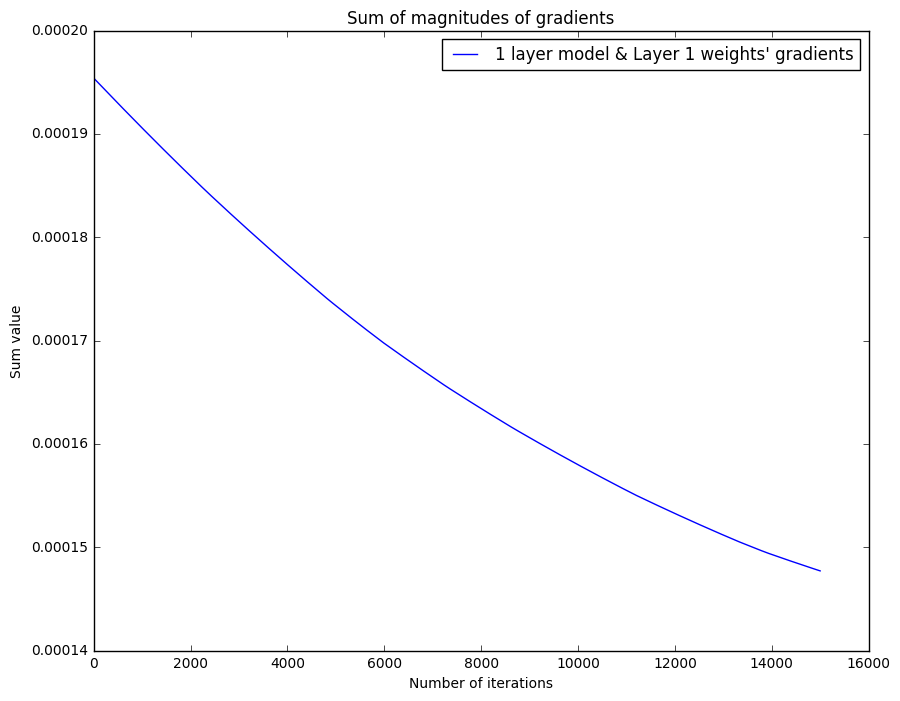

In [25]:
plot_gradients(models=[sgd_1layer_custom_init_sigmoid])

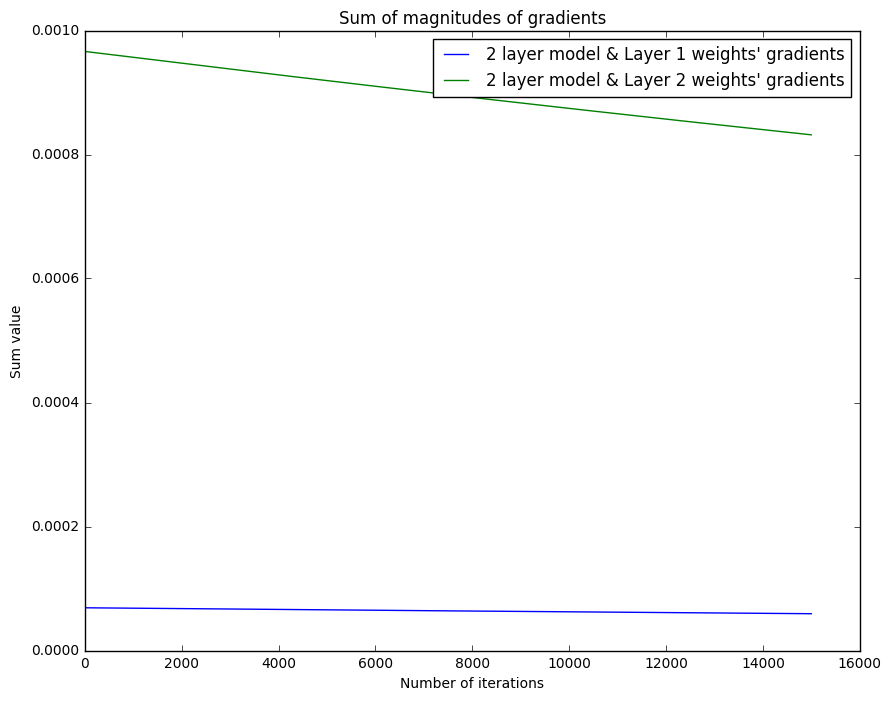

In [20]:
plot_gradients(models=[sgd_2layer_custom_init_sigmoid])

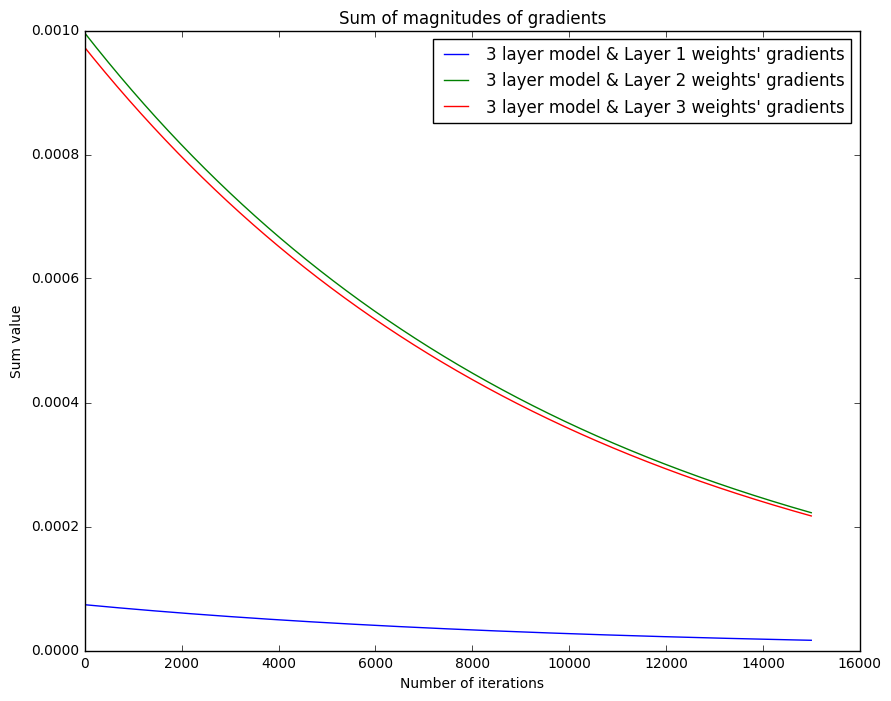

In [24]:
plot_gradients(models=[sgd_3layer_custom_init_sigmoid])

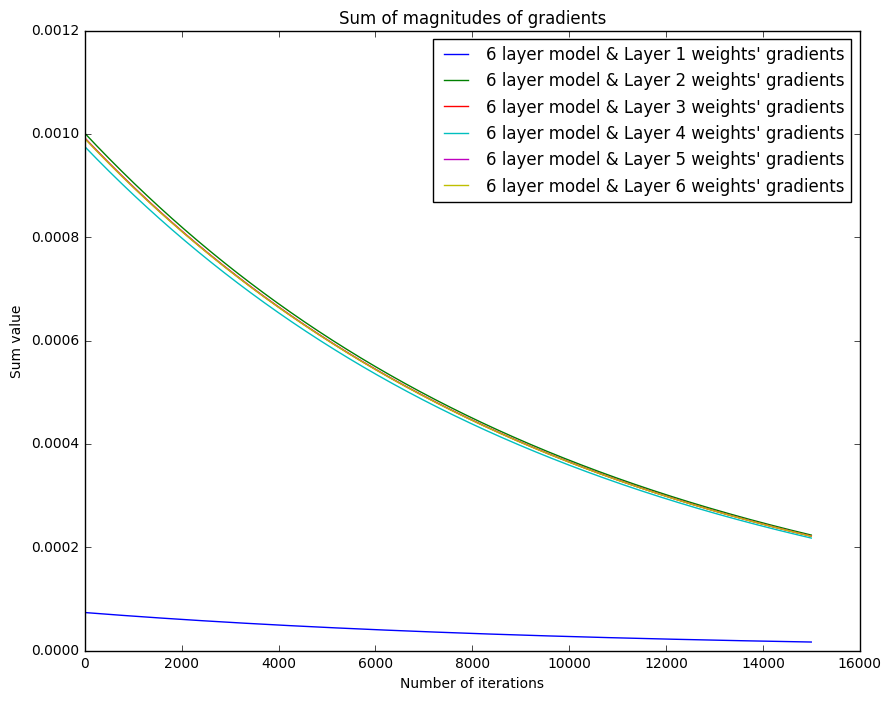

In [21]:
plot_gradients(models=[sgd_6layer_custom_init_sigmoid])

### Let's zoom in a bit

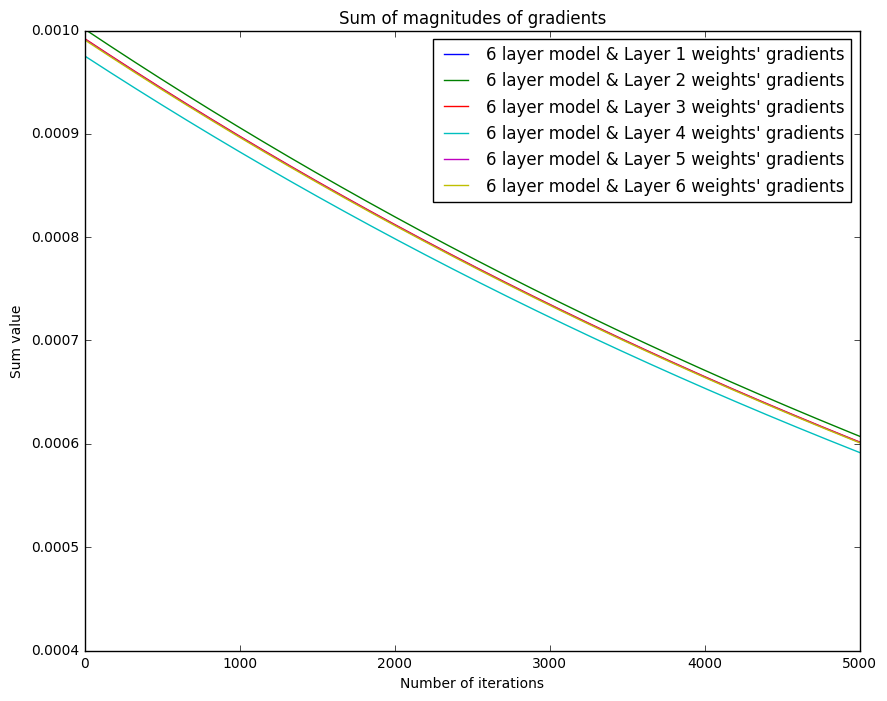

In [23]:
plot_gradients(models=[sgd_6layer_custom_init_sigmoid], axes_limits=[0,5000,0.0004,0.001])

### Plot gradients for specified layers across different models

#### Here, we are plotting the gradients for the first layer for all our above models

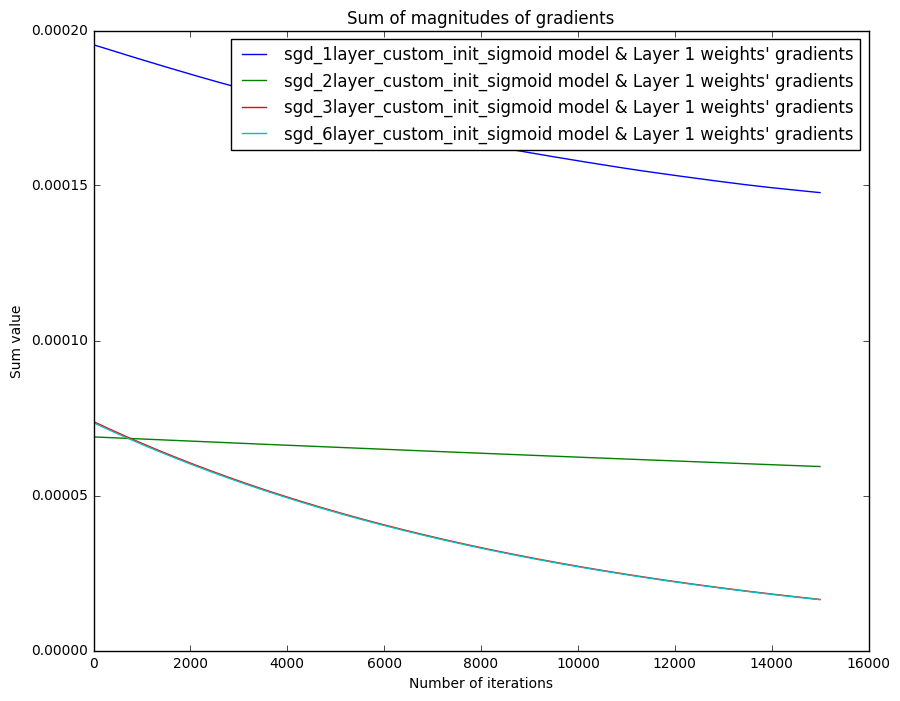

In [26]:
models = [sgd_1layer_custom_init_sigmoid,sgd_2layer_custom_init_sigmoid,sgd_3layer_custom_init_sigmoid, sgd_6layer_custom_init_sigmoid]
model_names = ["sgd_1layer_custom_init_sigmoid","sgd_2layer_custom_init_sigmoid","sgd_3layer_custom_init_sigmoid","sgd_6layer_custom_init_sigmoid"]
plot_gradients(models=models, model_names=model_names, layer_indices=[0])

### The effect of weights initialization on neural network training

#### Let's initialize all weights as zeros

In [27]:
sgd_4layer_zero_init = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*4), learning_rate=1e-1, 
                                        num_iterations=15000, W_init_type='zeros', activation_function='sigmoid')

#### Now train the model

In [28]:
sgd_4layer_zero_init.fit(X,y)

iteration 0: loss 1.098612
iteration 1000: loss 1.098612
iteration 2000: loss 1.098612
iteration 3000: loss 1.098612
iteration 4000: loss 1.098612
iteration 5000: loss 1.098612
iteration 6000: loss 1.098612
iteration 7000: loss 1.098612
iteration 8000: loss 1.098612
iteration 9000: loss 1.098612
iteration 10000: loss 1.098612
iteration 11000: loss 1.098612
iteration 12000: loss 1.098612
iteration 13000: loss 1.098612
iteration 14000: loss 1.098612


In [29]:
sgd_4layer_zero_init.accuracy(X,y)

training accuracy: 0.33


^^ So basically the weights aren't updated when they are initialized with zeros and the loss stays constant. This makes sense as essentially we have a constant function with zero gradient when the weights are all zeros.

#### Now let's initialize the weights using two popular techniques - Glorot/Xavier initialization and Kaiming initialization. 
http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf (Glorot/Xavier)

https://arxiv.org/abs/1502.01852 (Kaiming)

#### Glorot/Xavier initialization

In [49]:
sgd_1layer_glorot_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*1), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='glorot', activation_function='sigmoid', track_gradients=True)
sgd_1layer_glorot_sigmoid.fit(X,y)
sgd_1layer_glorot_sigmoid.accuracy(X,y)

iteration 0: loss 1.103049
iteration 1000: loss 1.098837
iteration 2000: loss 1.095843
iteration 3000: loss 1.092893
iteration 4000: loss 1.088834
iteration 5000: loss 1.080395
iteration 6000: loss 1.024991
iteration 7000: loss 0.912398
iteration 8000: loss 0.802406
iteration 9000: loss 0.771764
iteration 10000: loss 0.759345
iteration 11000: loss 0.753757
iteration 12000: loss 0.751316
iteration 13000: loss 0.750354
iteration 14000: loss 0.750114
training accuracy: 0.55


#### Kaiming initialization

In [58]:
sgd_1layer_kaiming_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*1), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='kaiming', activation_function='sigmoid', track_gradients=True)
sgd_1layer_kaiming_sigmoid.fit(X,y)
sgd_1layer_kaiming_sigmoid.accuracy(X,y)

iteration 0: loss 1.147138
iteration 1000: loss 1.078030
iteration 2000: loss 0.939938
iteration 3000: loss 0.846487
iteration 4000: loss 0.820363
iteration 5000: loss 0.810503
iteration 6000: loss 0.803592
iteration 7000: loss 0.798431
iteration 8000: loss 0.794089
iteration 9000: loss 0.788949
iteration 10000: loss 0.781217
iteration 11000: loss 0.773632
iteration 12000: loss 0.768854
iteration 13000: loss 0.766015
iteration 14000: loss 0.764277
training accuracy: 0.58


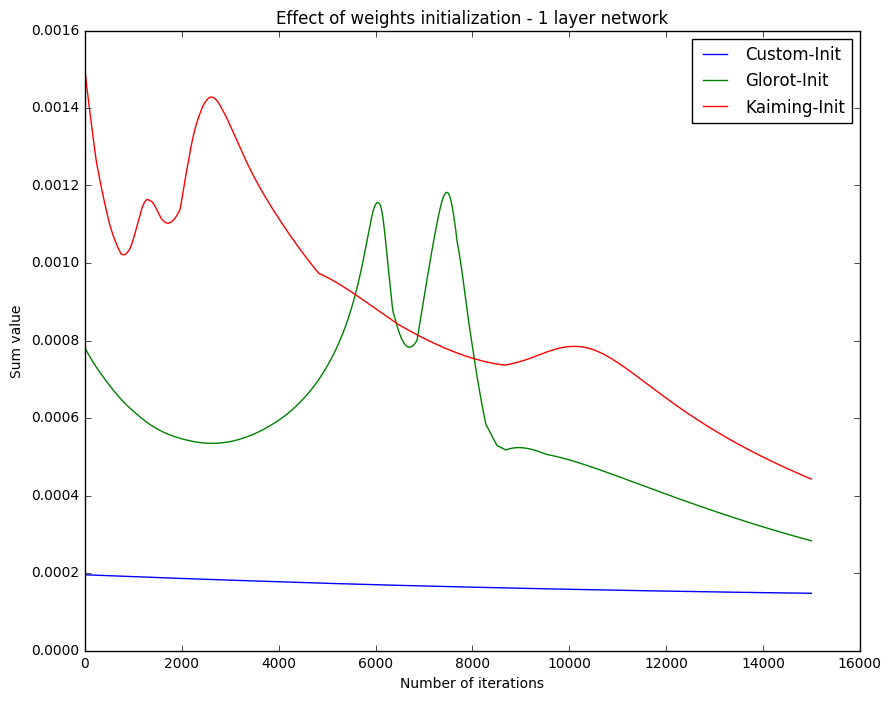

In [80]:
plot_gradients(models=[sgd_1layer_custom_init_sigmoid, sgd_1layer_glorot_sigmoid, sgd_1layer_kaiming_sigmoid], 
               custom_legend=['Custom-Init','Glorot-Init','Kaiming-Init'],
              title='Effect of weights initialization - 1 layer network')

In [51]:
sgd_2layer_glorot_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*2), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='glorot', activation_function='sigmoid', track_gradients=True)
sgd_2layer_glorot_sigmoid.fit(X,y)
sgd_2layer_glorot_sigmoid.accuracy(X,y)

iteration 0: loss 1.128878
iteration 1000: loss 1.123145
iteration 2000: loss 1.118704
iteration 3000: loss 1.115067
iteration 4000: loss 1.112089
iteration 5000: loss 1.109649
iteration 6000: loss 1.107651
iteration 7000: loss 1.106015
iteration 8000: loss 1.104675
iteration 9000: loss 1.103577
iteration 10000: loss 1.102678
iteration 11000: loss 1.101942
iteration 12000: loss 1.101339
iteration 13000: loss 1.100845
iteration 14000: loss 1.100441
training accuracy: 0.33


In [66]:
sgd_2layer_kaiming_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*2), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='kaiming', activation_function='sigmoid', track_gradients=True)
sgd_2layer_kaiming_sigmoid.fit(X,y)
sgd_2layer_kaiming_sigmoid.accuracy(X,y)

iteration 0: loss 1.203616
iteration 1000: loss 1.184406
iteration 2000: loss 1.168914
iteration 3000: loss 1.156230
iteration 4000: loss 1.145840
iteration 5000: loss 1.137327
iteration 6000: loss 1.130349
iteration 7000: loss 1.124629
iteration 8000: loss 1.119939
iteration 9000: loss 1.116094
iteration 10000: loss 1.112942
iteration 11000: loss 1.110357
iteration 12000: loss 1.108238
iteration 13000: loss 1.106501
iteration 14000: loss 1.105077
training accuracy: 0.48


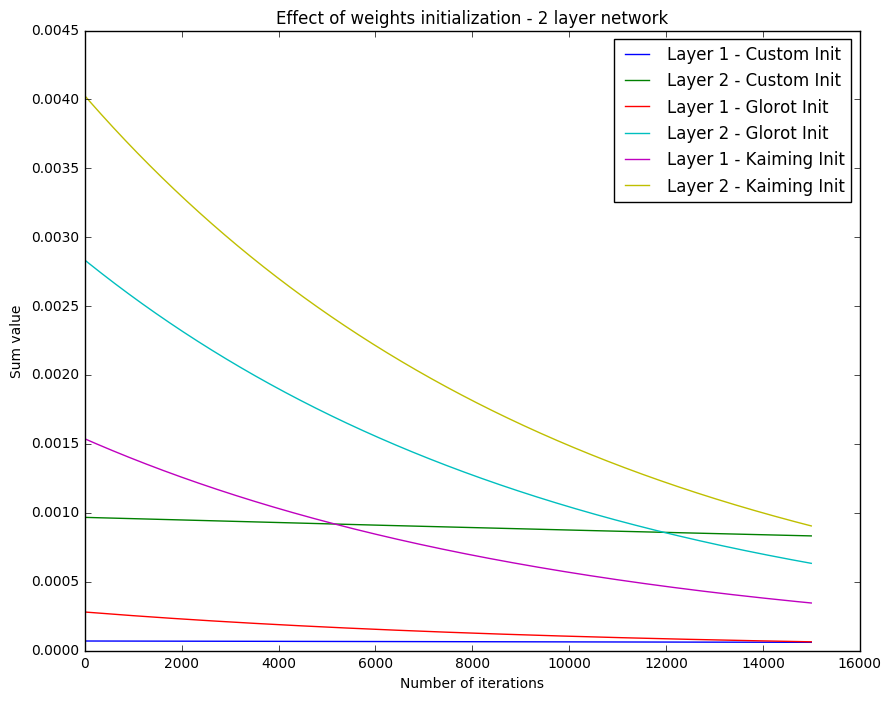

In [79]:
plot_gradients(models=[sgd_2layer_custom_init_sigmoid, sgd_2layer_glorot_sigmoid, sgd_2layer_kaiming_sigmoid], 
               custom_legend=['Layer 1 - Custom Init','Layer 2 - Custom Init',
                              'Layer 1 - Glorot Init','Layer 2 - Glorot Init',
                              'Layer 1 - Kaiming Init','Layer 2 - Kaiming Init'],
               title='Effect of weights initialization - 2 layer network')

In [68]:
sgd_6layer_kaiming_sigmoid = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*6), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='kaiming', activation_function='sigmoid', track_gradients=True)
sgd_6layer_kaiming_sigmoid.fit(X,y)
sgd_6layer_kaiming_sigmoid.accuracy(X,y)

iteration 0: loss 1.410727
iteration 1000: loss 1.353809
iteration 2000: loss 1.307548
iteration 3000: loss 1.269673
iteration 4000: loss 1.238663
iteration 5000: loss 1.213275
iteration 6000: loss 1.192490
iteration 7000: loss 1.175472
iteration 8000: loss 1.161539
iteration 9000: loss 1.150132
iteration 10000: loss 1.140793
iteration 11000: loss 1.133146
iteration 12000: loss 1.126886
iteration 13000: loss 1.121761
iteration 14000: loss 1.117564
training accuracy: 0.33


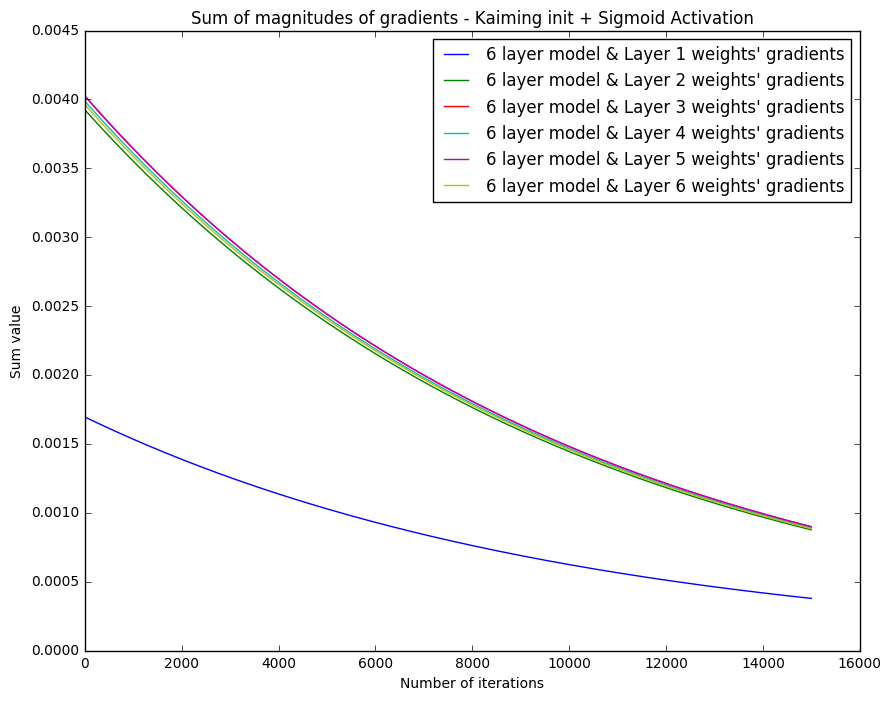

In [84]:
plot_gradients(models=[sgd_6layer_kaiming_sigmoid], title="Sum of magnitudes of gradients - Kaiming init + Sigmoid Activation")

### Conclusion: We observe that robust initialization leads to better convergence and training error rates. However, the gain diminishes as the number of hidden layers increase

### Let's now tune another parameter - the activation function of the hidden layers.
### Let's repeat some of the above experiments with ReLU activation.

To start with, let's take the 6 layer model above and switch it to use ReLU instead of sigmoid activations

In [71]:
sgd_6layer_kaiming_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*6), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='kaiming', activation_function='relu', track_gradients=True)
sgd_6layer_kaiming_relu.fit(X,y)
sgd_6layer_kaiming_relu.accuracy(X,y)

iteration 0: loss 1.462005
iteration 1000: loss 0.278674
iteration 2000: loss 0.237192
iteration 3000: loss 0.205940
iteration 4000: loss 0.180584
iteration 5000: loss 0.162043
iteration 6000: loss 0.142972
iteration 7000: loss 0.127061
iteration 8000: loss 0.115988
iteration 9000: loss 0.106518
iteration 10000: loss 0.097407
iteration 11000: loss 0.091557
iteration 12000: loss 0.089073
iteration 13000: loss 0.082923
iteration 14000: loss 0.078481
training accuracy: 0.99


In [106]:
sgd_6layer_glorot_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*6), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='glorot', activation_function='relu', track_gradients=True)
sgd_6layer_glorot_relu.fit(X,y)
sgd_6layer_glorot_relu.accuracy(X,y)

iteration 0: loss 1.223842
iteration 1000: loss 0.180359
iteration 2000: loss 0.146642
iteration 3000: loss 0.130157
iteration 4000: loss 0.118255
iteration 5000: loss 0.107017
iteration 6000: loss 0.100696
iteration 7000: loss 0.091904
iteration 8000: loss 0.086489
iteration 9000: loss 0.090492
iteration 10000: loss 0.083665
iteration 11000: loss 0.078769
iteration 12000: loss 0.074950
iteration 13000: loss 0.073247
iteration 14000: loss 0.073013
training accuracy: 0.99


In [112]:
sgd_6layer_custom_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*6), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='0.05_sigma', activation_function='relu', track_gradients=True)
sgd_6layer_custom_relu.fit(X,y)
sgd_6layer_custom_relu.accuracy(X,y)

iteration 0: loss 1.114575
iteration 1000: loss 1.111672
iteration 2000: loss 1.109318
iteration 3000: loss 1.107387
iteration 4000: loss 1.105803
iteration 5000: loss 1.104504
iteration 6000: loss 1.103438
iteration 7000: loss 1.102564
iteration 8000: loss 1.101848
iteration 9000: loss 1.101262
iteration 10000: loss 1.100782
iteration 11000: loss 1.100389
iteration 12000: loss 1.100067
iteration 13000: loss 1.099803
iteration 14000: loss 1.099587
training accuracy: 0.33


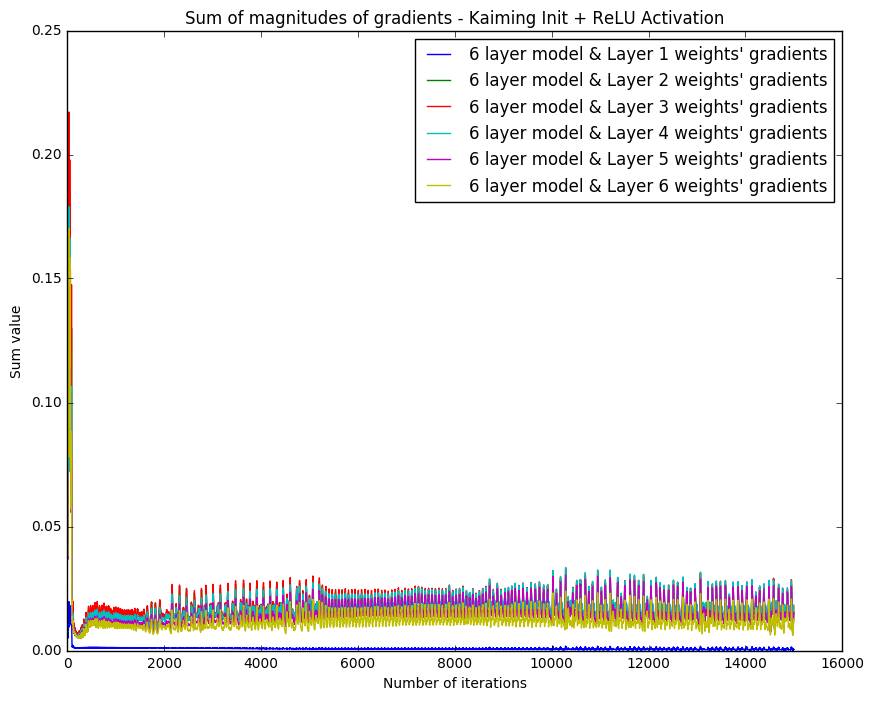

In [81]:
plot_gradients(models=[sgd_6layer_kaiming_relu],title="Sum of magnitudes of gradients - Kaiming Init + ReLU Activation")

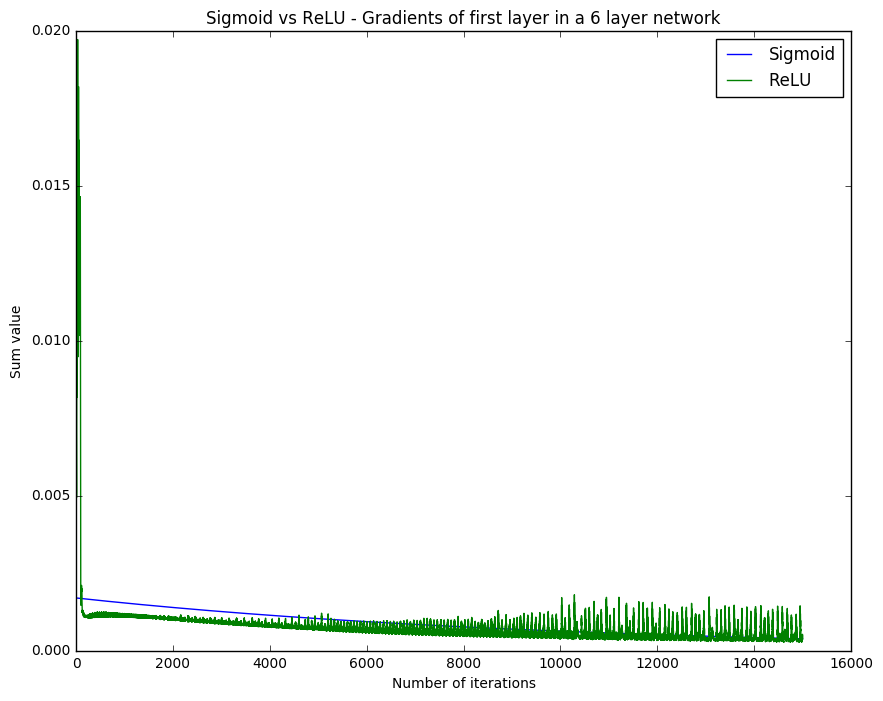

In [85]:
plot_gradients(models=[sgd_6layer_kaiming_sigmoid,sgd_6layer_kaiming_relu],layer_indices=[0],
               custom_legend=['Sigmoid','ReLU'], title='Sigmoid vs ReLU - Gradients of first layer in a 6 layer network')

In [86]:
sgd_1layer_kaiming_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*1), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='kaiming', activation_function='relu', track_gradients=True)
sgd_1layer_kaiming_relu.fit(X,y)
sgd_1layer_kaiming_relu.accuracy(X,y)

iteration 0: loss 1.114784
iteration 1000: loss 0.334726
iteration 2000: loss 0.276878
iteration 3000: loss 0.261026
iteration 4000: loss 0.254876
iteration 5000: loss 0.252032
iteration 6000: loss 0.250298
iteration 7000: loss 0.249167
iteration 8000: loss 0.248453
iteration 9000: loss 0.247922
iteration 10000: loss 0.247512
iteration 11000: loss 0.247184
iteration 12000: loss 0.246804
iteration 13000: loss 0.246453
iteration 14000: loss 0.246082
training accuracy: 0.98


In [95]:
sgd_1layer_glorot_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*1), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='glorot', activation_function='relu', track_gradients=True)
sgd_1layer_glorot_relu.fit(X,y)
sgd_1layer_glorot_relu.accuracy(X,y)

iteration 0: loss 1.102030
iteration 1000: loss 0.514749
iteration 2000: loss 0.363250
iteration 3000: loss 0.315652
iteration 4000: loss 0.290978
iteration 5000: loss 0.277155
iteration 6000: loss 0.269253
iteration 7000: loss 0.264165
iteration 8000: loss 0.260928
iteration 9000: loss 0.258501
iteration 10000: loss 0.256434
iteration 11000: loss 0.254382
iteration 12000: loss 0.252798
iteration 13000: loss 0.251514
iteration 14000: loss 0.250514
training accuracy: 0.98


In [97]:
sgd_1layer_custom_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*1), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='0.05_sigma', activation_function='relu', track_gradients=True)
sgd_1layer_custom_relu.fit(X,y)
sgd_1layer_custom_relu.accuracy(X,y)

iteration 0: loss 1.099162
iteration 1000: loss 0.690747
iteration 2000: loss 0.510767
iteration 3000: loss 0.380813
iteration 4000: loss 0.337824
iteration 5000: loss 0.314044
iteration 6000: loss 0.298465
iteration 7000: loss 0.286702
iteration 8000: loss 0.279477
iteration 9000: loss 0.275116
iteration 10000: loss 0.272101
iteration 11000: loss 0.269881
iteration 12000: loss 0.267539
iteration 13000: loss 0.265263
iteration 14000: loss 0.262636
training accuracy: 0.97


In [88]:
sgd_2layer_kaiming_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*2), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='kaiming', activation_function='relu', track_gradients=True)
sgd_2layer_kaiming_relu.fit(X,y)
sgd_2layer_kaiming_relu.accuracy(X,y)

iteration 0: loss 1.284169
iteration 1000: loss 0.189324
iteration 2000: loss 0.169005
iteration 3000: loss 0.158117
iteration 4000: loss 0.150333
iteration 5000: loss 0.144364
iteration 6000: loss 0.139619
iteration 7000: loss 0.135785
iteration 8000: loss 0.132706
iteration 9000: loss 0.130208
iteration 10000: loss 0.128158
iteration 11000: loss 0.126476
iteration 12000: loss 0.125084
iteration 13000: loss 0.123917
iteration 14000: loss 0.122935
training accuracy: 0.99


In [89]:
sgd_3layer_kaiming_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*3), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='kaiming', activation_function='relu', track_gradients=True)
sgd_3layer_kaiming_relu.fit(X,y)
sgd_3layer_kaiming_relu.accuracy(X,y)

iteration 0: loss 1.320907
iteration 1000: loss 0.189007
iteration 2000: loss 0.166024
iteration 3000: loss 0.149992
iteration 4000: loss 0.137367
iteration 5000: loss 0.127207
iteration 6000: loss 0.118990
iteration 7000: loss 0.112372
iteration 8000: loss 0.106998
iteration 9000: loss 0.102599
iteration 10000: loss 0.099000
iteration 11000: loss 0.096071
iteration 12000: loss 0.093671
iteration 13000: loss 0.091682
iteration 14000: loss 0.090031
training accuracy: 0.99


In [100]:
sgd_3layer_glorot_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*3), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='glorot', activation_function='relu', track_gradients=True)
sgd_3layer_glorot_relu.fit(X,y)
sgd_3layer_glorot_relu.accuracy(X,y)

iteration 0: loss 1.149809
iteration 1000: loss 0.142998
iteration 2000: loss 0.122278
iteration 3000: loss 0.113970
iteration 4000: loss 0.108212
iteration 5000: loss 0.103602
iteration 6000: loss 0.099850
iteration 7000: loss 0.096722
iteration 8000: loss 0.094128
iteration 9000: loss 0.091965
iteration 10000: loss 0.090146
iteration 11000: loss 0.088638
iteration 12000: loss 0.087372
iteration 13000: loss 0.086299
iteration 14000: loss 0.085393
training accuracy: 0.99


In [99]:
sgd_3layer_custom_relu = MultiLayerSGDNeuralNetwork(input_shape=(N*K,D), labels_shape=(N*K,), num_classes=K, 
                              num_hidden_nodes=np.array([50]*3), learning_rate=1e-1, num_iterations=15000,
                                               W_init_type='0.05_sigma', activation_function='relu', track_gradients=True)
sgd_3layer_custom_relu.fit(X,y)
sgd_3layer_custom_relu.accuracy(X,y)

iteration 0: loss 1.105078
iteration 1000: loss 0.648947
iteration 2000: loss 0.124866
iteration 3000: loss 0.096970
iteration 4000: loss 0.091645
iteration 5000: loss 0.089043
iteration 6000: loss 0.087224
iteration 7000: loss 0.086048
iteration 8000: loss 0.085090
iteration 9000: loss 0.084287
iteration 10000: loss 0.083589
iteration 11000: loss 0.082872
iteration 12000: loss 0.082351
iteration 13000: loss 0.081845
iteration 14000: loss 0.081427
training accuracy: 0.99


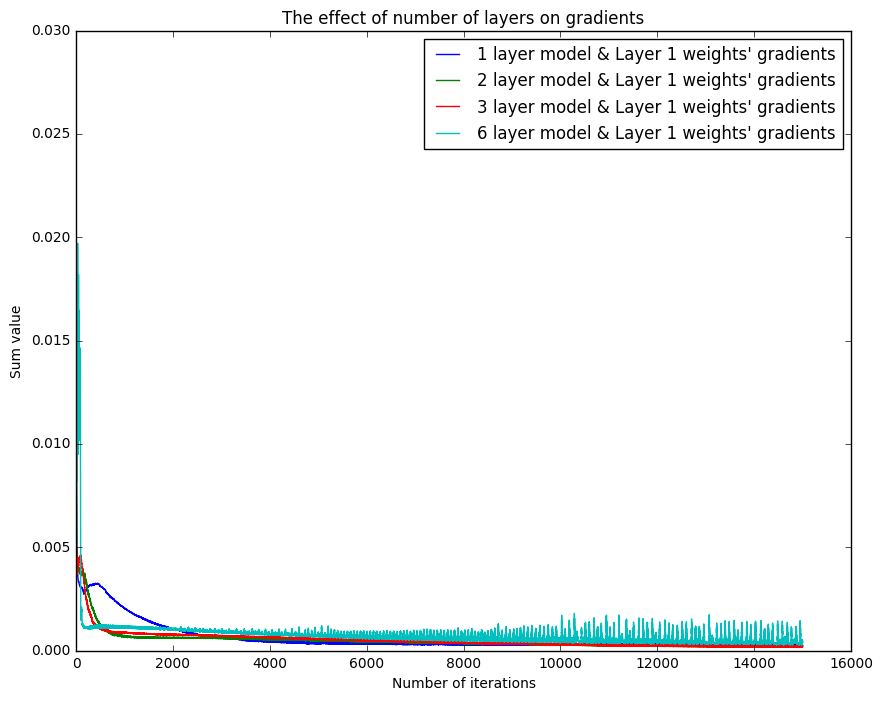

In [94]:
plot_gradients(models=[sgd_1layer_kaiming_relu, sgd_2layer_kaiming_relu, sgd_3layer_kaiming_relu, sgd_6layer_kaiming_relu],
               layer_indices=[0],
               title="The effect of number of layers on gradients")

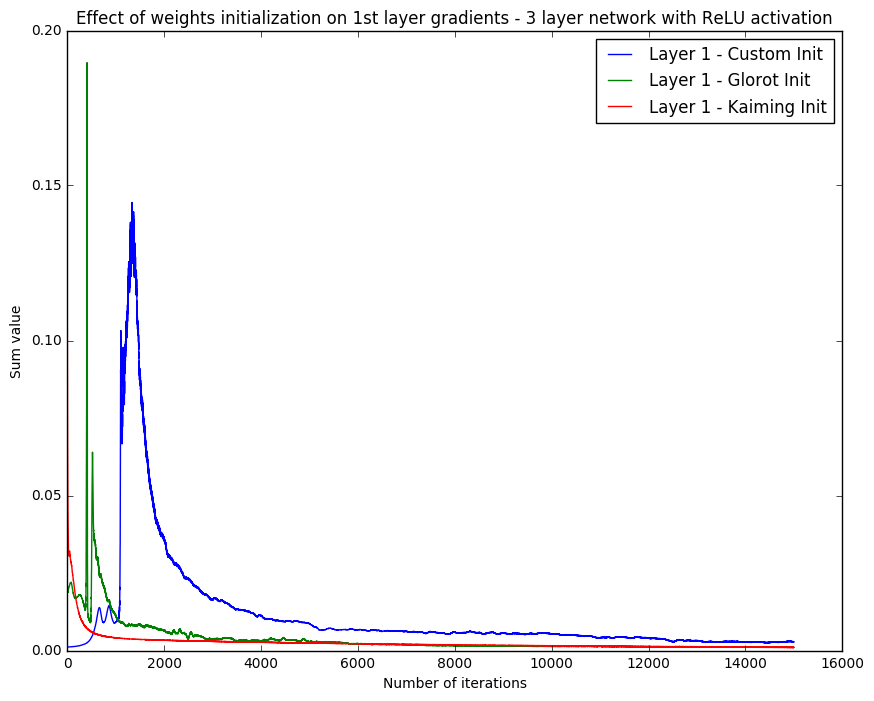

In [104]:
plot_gradients(models=[sgd_3layer_custom_relu, sgd_3layer_glorot_relu, sgd_3layer_kaiming_relu], 
               layer_indices=[2],
               custom_legend=['Layer 1 - Custom Init',
                              'Layer 1 - Glorot Init',
                              'Layer 1 - Kaiming Init'],
               title='Effect of weights initialization on 1st layer gradients - 3 layer network with ReLU activation')

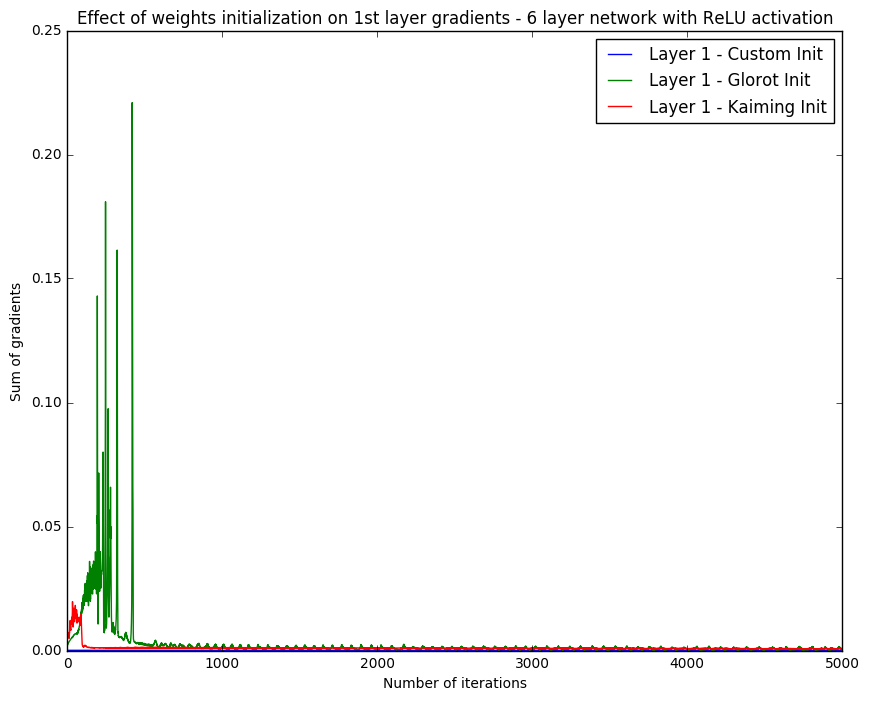

In [109]:
plot_gradients(models=[sgd_6layer_custom_relu, sgd_6layer_glorot_relu, sgd_6layer_kaiming_relu], 
               layer_indices=[0],
               custom_legend=['Layer 1 - Custom Init',
                              'Layer 1 - Glorot Init',
                              'Layer 1 - Kaiming Init'],
               title='Effect of weights initialization on 1st layer gradients - 6 layer network with ReLU activation',
              axes_limits=[0,5000,0,0.25])

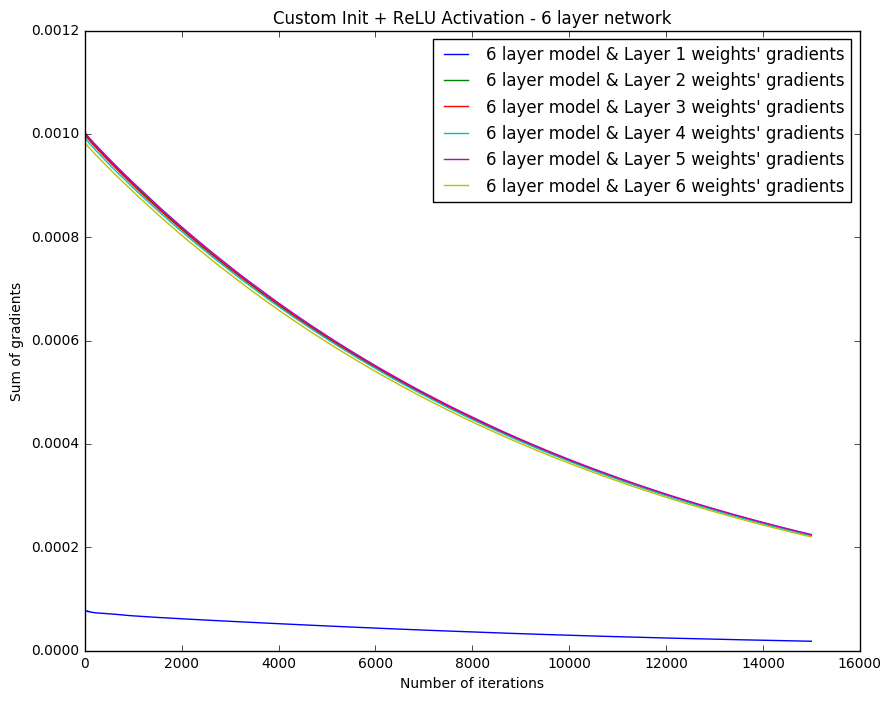

In [115]:
plot_gradients(models=[sgd_6layer_custom_relu], title="Custom Init + ReLU Activation - 6 layer network")

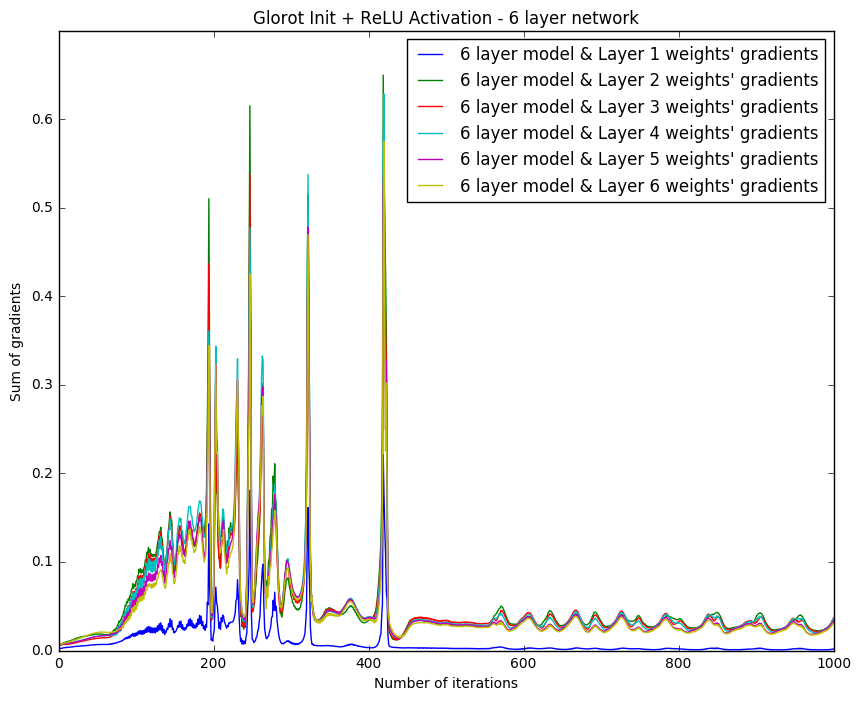

In [120]:
plot_gradients(models=[sgd_6layer_glorot_relu], title="Glorot Init + ReLU Activation - 6 layer network", axes_limits=[0,1000,0,0.7])

### A few observations:
    - We finally see the desired effect that the performance of the model improves as we increase the number of layers
    - The convergence rate with ReLU is higher than that with sigmoid activation
    - There is not always a "winning" parameter combination. It is useful to plot things like above for different parameters of the network inorder to achieve the ideal result
    - On a similar note, it is the combination of parameters that matter and not any specific individual parameter. For instance, a 6-layer network with bad initialization but ReLU activations (sgd_6layer_custom_relu) on hidden layers is equally worse as a 6-layer network with good initialization and sigmoid activations (sgd_6layer_kaiming_sigmoid). To achieve the best performance, we needed a 6-layer network with good initialization and ReLU activations (sgd_6layer_kaiming_relu).